In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.17.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import io
import os
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import layers

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=70
NUM_CLASSES = 5

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "processed_images",
    shuffle=True ,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7204 files belonging to 5 classes.


In [6]:
class_names=dataset.class_names
class_names

['1. Eczema',
 '2. Melanoma',
 '4. Basal Cell Carcinoma(BCC)',
 '5. Melanocytic Nevi (NV)',
 '7. Psoriasis pictures Lichen Planus and related diseases']

In [7]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 3 2 1 4 1 4 0 3 4 3 3 2 1 2 2 4 4 3 1 0 2 1 2 2 3 0 1 3 0 0 0]


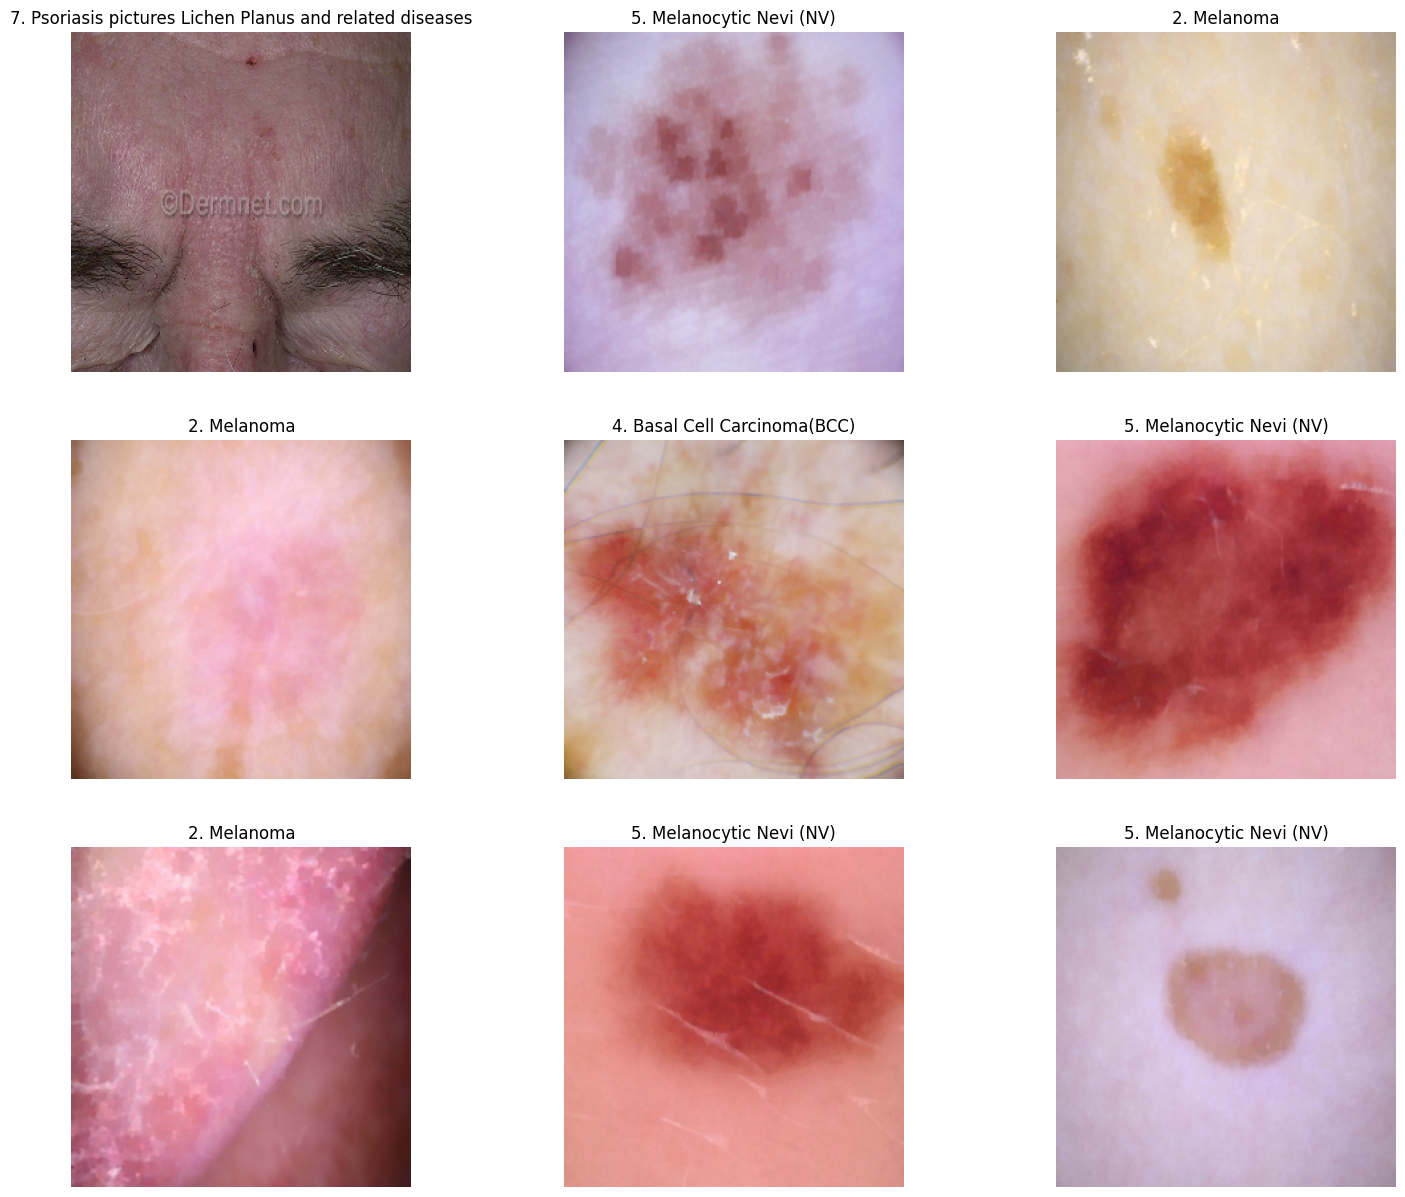

In [8]:
plt.figure(figsize=(18,15))
for i in range(9):
    for image_batch , label_batch in dataset.take(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        # print(image_batch[0].shape)
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.7 , test_split=0.2 , val_split=0.1, shuffle=True , shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size , seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
    return train_ds ,val_ds ,  test_ds 

In [10]:
train_ds , val_ds , test_ds =get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

158

In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.2),
])

In [15]:

input_shape=(BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5
model_cnn= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu' , input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),  
])
model_cnn.build(input_shape=input_shape)

c:\Users\Padidar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history_cnn = model_cnn.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 562ms/step - accuracy: 0.3291 - loss: 1.4355 - val_accuracy: 0.5185 - val_loss: 1.0347
Epoch 2/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - accuracy: 0.5249 - loss: 1.0068 - val_accuracy: 0.6009 - val_loss: 0.7856
Epoch 3/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.5821 - loss: 0.8972 - val_accuracy: 0.5881 - val_loss: 0.8517
Epoch 4/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - accuracy: 0.6008 - loss: 0.8456 - val_accuracy: 0.5895 - val_loss: 0.8461
Epoch 5/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - accuracy: 0.6289 - loss: 0.8100 - val_accuracy: 0.6619 - val_loss: 0.6798
Epoch 6/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 567ms/step - accuracy: 0.6655 - loss: 0.7206 - val_accuracy: 0.6818 - val_loss: 0.6692
Epoch 7/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.6671 - loss: 0.6998 - val_accuracy: 0.6534 - val_loss: 0.7094
Epoch 8/70
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.6718 - loss: 0

In [19]:
scores=model_cnn.evaluate(test_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8057 - loss: 0.4278


In [20]:
history_cnn.params

{'verbose': 1, 'epochs': 70, 'steps': 158}

In [21]:
acc_resnet=history_cnn.history['accuracy']
val_acc_resnet=history_cnn.history['val_accuracy']


loss_resnet=history_cnn.history['loss']
val_loss_resnet=history_cnn.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy for ResNet-50')

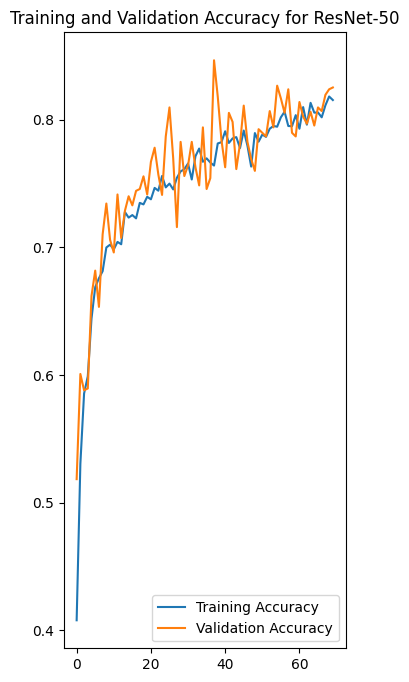

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc_resnet, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc_resnet,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for ResNet-50')

In [23]:
model_cnn.save("my_model_cnn_sample2.keras")